In [1]:
import numpy as np
import os
from astropy.io import fits
from scipy.ndimage import gaussian_filter, generic_filter
import matplotlib.pyplot as plt

## Calculate number of bad pixels and spatial noise

In [2]:
def count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size):
    # Calculate local mean and standard deviation for each pixel
    local_mean = gaussian_filter(image_data, sigma=neighborhood_size)
    local_std = np.sqrt(gaussian_filter((image_data - local_mean)**2, sigma=neighborhood_size))

    # Define thresholds
    upper_threshold = local_mean + threshold_factor * local_std
    lower_threshold = local_mean - threshold_factor * local_std

    # Identify bad pixels based on thresholding
    hot_pixels = image_data > upper_threshold
    cold_pixels = image_data < lower_threshold
    bad_pixel_mask = hot_pixels | cold_pixels  # Combine masks for hot and cold pixels

    # Coordinates of bad pixels
    bad_pixel_coords = np.argwhere(bad_pixel_mask)
    num_bad_pixels = len(bad_pixel_coords)

    return num_bad_pixels, bad_pixel_coords, bad_pixel_mask

def process_image(fits_filename, threshold_factor, neighborhood_size, window_size):
    hdul = fits.open(fits_filename)
    image_data = hdul[0].data
    #.data.astype(np.int32)
    hdul.close()

    # Count and locate bad pixels
    num_bad_pixels, bad_pixel_coords, bad_pixel_mask = count_and_locate_bad_pixels(image_data, 
                                                                                   threshold_factor, neighborhood_size)

    print(f"Number of bad pixels in {fits_filename}:", num_bad_pixels)
    print(f"Coordinates of bad pixels in {fits_filename}:", bad_pixel_coords)
    
    
    # Calculate spatial noise using window method
#     noise_image = generic_filter(image_data, np.std, size=window_size)

#     # Plot the noise image
#     plt.figure(figsize=(10, 8))
#     plt.imshow(noise_image, cmap='viridis', origin='lower')
#     plt.colorbar(label='Noise (Standard Deviation)')
#     plt.title(f'Noise image for {fits_filename}')
#     plt.xlabel('X Pixels')
#     plt.ylabel('Y Pixels')
#     plt.show()
    plt.figure(figsize=(10, 8))
    plt.imshow(image_data, cmap='gray', origin='lower')
    plt.scatter(bad_pixel_coords[:, 1], bad_pixel_coords[:, 0], color='red', s=1, label='Bad Pixels')
    plt.title(f'Bad Pixels in a single frame', fontsize=20)
    plt.xlabel('X Pixels', fontsize=16)
    plt.ylabel('Y Pixels', fontsize=16)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

Testing with threshold factor: 80
Number of bad pixels in ramp_mode_single_ended/4ramp_1c_1read_1reset_1g/H2RG_Slow_FullWin_20241125_000001.fits: 932
Coordinates of bad pixels in ramp_mode_single_ended/4ramp_1c_1read_1reset_1g/H2RG_Slow_FullWin_20241125_000001.fits: [[   5  553]
 [   5 1382]
 [   6  352]
 ...
 [2047  765]
 [2047  766]
 [2047  767]]


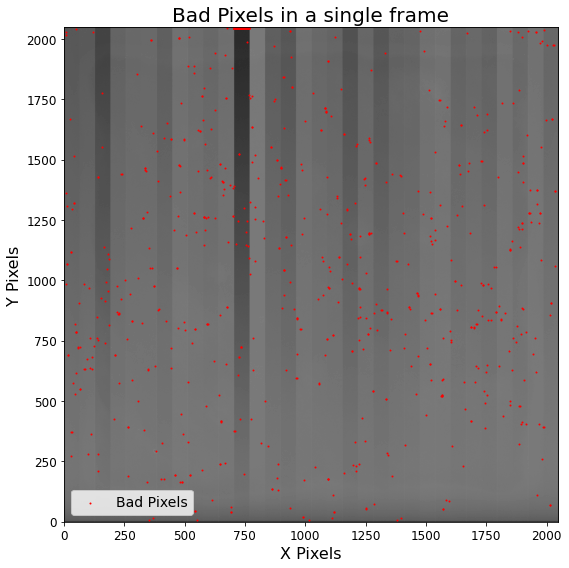

Testing with threshold factor: 100
Number of bad pixels in ramp_mode_single_ended/4ramp_1c_1read_1reset_1g/H2RG_Slow_FullWin_20241125_000001.fits: 805
Coordinates of bad pixels in ramp_mode_single_ended/4ramp_1c_1read_1reset_1g/H2RG_Slow_FullWin_20241125_000001.fits: [[   5  553]
 [   5 1382]
 [   6 1015]
 ...
 [2047  765]
 [2047  766]
 [2047  767]]


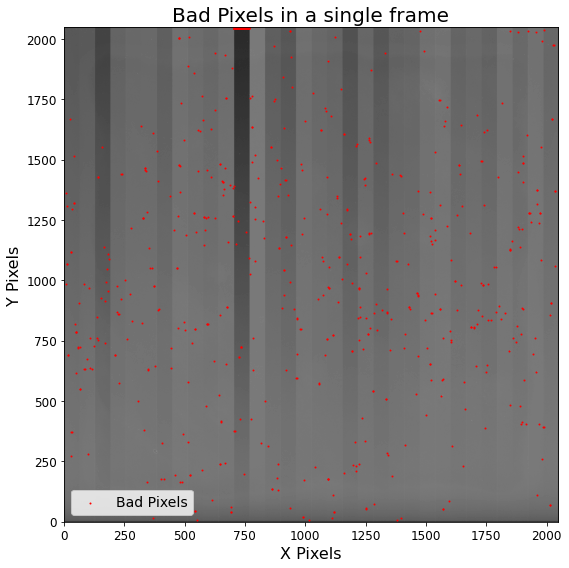

Testing with threshold factor: 200
Number of bad pixels in ramp_mode_single_ended/4ramp_1c_1read_1reset_1g/H2RG_Slow_FullWin_20241125_000001.fits: 0
Coordinates of bad pixels in ramp_mode_single_ended/4ramp_1c_1read_1reset_1g/H2RG_Slow_FullWin_20241125_000001.fits: []


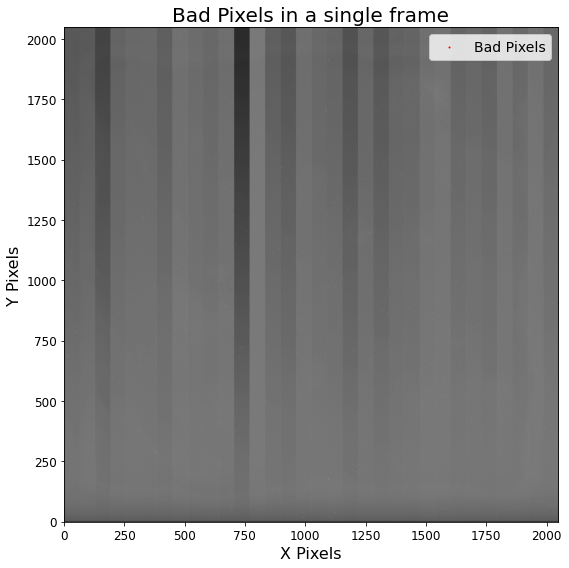

Testing with threshold factor: 300
Number of bad pixels in ramp_mode_single_ended/4ramp_1c_1read_1reset_1g/H2RG_Slow_FullWin_20241125_000001.fits: 0
Coordinates of bad pixels in ramp_mode_single_ended/4ramp_1c_1read_1reset_1g/H2RG_Slow_FullWin_20241125_000001.fits: []


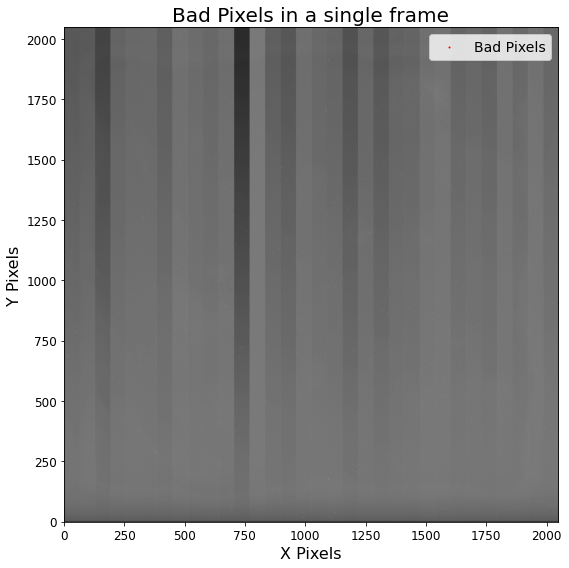

In [3]:
threshold_factors = [80,100,200,300] # try different values in the list
neighborhood_size = 80  # Adjust this size
window_size = 10  # Adjust this size


fits_filenames = ["ramp_mode_single_ended/4ramp_1c_1read_1reset_1g/H2RG_Slow_FullWin_20241125_000001.fits"]

for factor in threshold_factors:
    print(f"Testing with threshold factor: {factor}")
    for fits_filename in fits_filenames:
        process_image(fits_filename, factor, neighborhood_size, window_size)

## Calculate temporal noise 

In [5]:
def calculate_temporal_noise(fits_filenames):
    # Read all FITS files and store the image data in a list
    image_data_list = []
    for fits_filename in fits_filenames:
        hdul = fits.open(fits_filename)
        image_data = hdul[0].data.astype(np.int32)
        hdul.close()
        image_data_list.append(image_data)
    
    # Stack the images along a new axis to create a 3D array (frames, height, width)
    stacked_images = np.stack(image_data_list, axis=0)
    
    # Calculate the standard deviation along the time axis to get temporal noise
    temporal_noise = np.std(stacked_images, axis=0)
    
    return temporal_noise

In [6]:
folder = "ramp_mode_single_ended/2ramp_1reset_2read"
fits_filenames = [os.path.join(folder, f"Frame_R0001_M0001_N0001.fits"),
                  os.path.join(folder, f"Frame_R0001_M0001_N0002.fits"),
                  os.path.join(folder, f"Frame_R0002_M0001_N0001.fits"),
                  os.path.join(folder, f"Frame_R0002_M0001_N0002.fits")]

# Calculate temporal noise
temporal_noise = calculate_temporal_noise(fits_filenames)

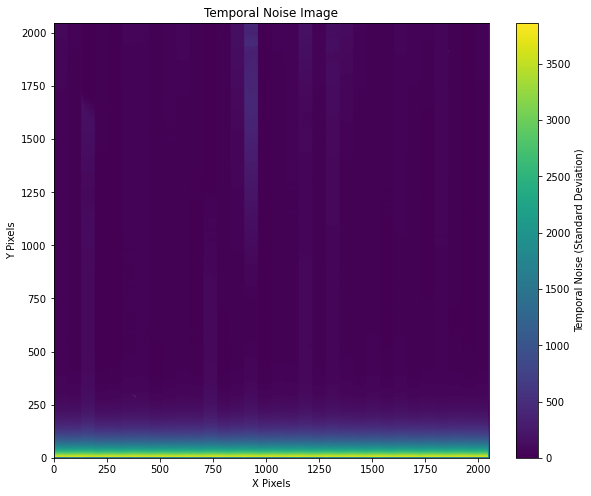

In [7]:
plt.figure(figsize=(10, 8))
plt.imshow(temporal_noise, cmap='viridis', origin='lower')
plt.colorbar(label='Temporal Noise (Standard Deviation)')
plt.title('Temporal Noise Image')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

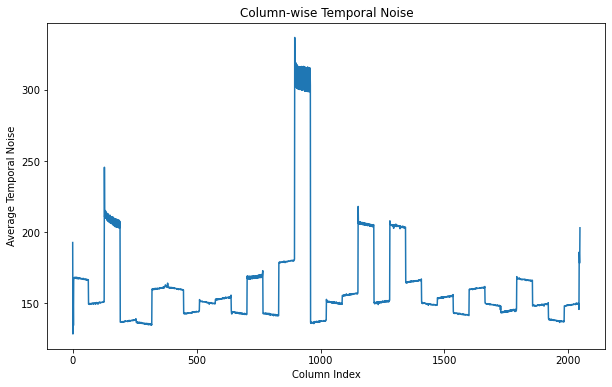

In [22]:
column_noise = np.mean(temporal_noise, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(column_noise)
plt.xlabel('Column Index')
plt.ylabel('Average Temporal Noise')
plt.title('Column-wise Temporal Noise')
plt.show()
